In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Input, InputLayer, MaxPool2D, UpSampling2D, BatchNormalization, Dropout, Conv2DTranspose, ReLU, Activation
from tensorflow.keras.backend import concatenate
import scipy.stats as ss
from scipy.stats import entropy, zscore, moment
import os
import time
import imageio
import random
import collections
import copy
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import chain
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize
from skimage import draw
from skimage.transform import rotate
from IPython.display import Image
!pip install tf-explain
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

TensorFlow 2.x selected.
     |████████████████████████████████| 51kB 2.9MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
im_dims = (32, 64, 1) # Image dimensions

In [0]:
class Shape(object):
    '''
    A class to generate shapes
    '''
    def __init__(self, size, size_range, pos, xgap, offset=0):
        '''
        size: size of object (circle: radius, other shapes: length)
        size_range: [mininmum size, maximum size] for given shape
        pos: initial position
        xgap: x-axis gap between shapes
        offset: y-axis offset/shift value of second shape (compared to first shape's y-axis position)
        '''
        self.size = size
        self.min_size, self.max_size = size_range[0], size_range[1]
        self.xgap = xgap
        self.pos = [pos[0] + xgap, pos[1] + offset] 
    
    def generate(self, drawFun, **kwargs):
        '''
        Drawing function
        Each shape has a drawing function provided by scikit-image

        returns: rows and columns of np array
        '''
        rr, cc = drawFun(**kwargs)
        return rr, cc   
        
class Circle(Shape):
    '''
    A class to generate circles
    '''
    def __init__(self, size=4, size_range=(2, 4), pos=[0,0], offset=0):
        self.xgap = size/2
        super().__init__(size, size_range, pos, self.xgap, offset)
    
    def generate(self):
        return super().generate(draw.circle, r=self.pos[0], c = self.pos[1], radius=self.size)

class Triangle(Shape):
    '''
    A class to generate triangles (as a polygon)
    '''
    def __init__(self, size=5, size_range=(3, 6), pos=[0,0], offset=0):
        self.xgap = 0
        super().__init__(size, size_range, pos, self.xgap, offset)
    
    def generate(self):
        poly = self.polygonArray()
        return super().generate(draw.polygon, r=poly[:,0], c=poly[:, 1])
    
    def polygonArray(self):
        '''
        Get all summits of triangle polygon
        '''
        return np.array((
                        (self.pos[0], self.pos[1]),
                        (self.pos[0] + np.sqrt(3)*self.size/2, self.pos[1]-self.size/2),
                        (self.pos[0] + np.sqrt(3)*self.size/2, self.pos[1]+self.size/2),
                        (self.pos[0], self.pos[1]), 
                        ))

class Diamond(Shape):
    '''
    A class to generate diamonds (as a polygon)
    '''
    def __init__(self, size=4, size_range=(3, 5), pos=[0,0], offset=0):
        self.xgap = size/4
        super().__init__(size, size_range, pos, self.xgap, offset)
    
    def generate(self):
        poly = self.polygonArray()
        return super().generate(draw.polygon, r=poly[:,0], c=poly[:, 1])

    def polygonArray(self):
        '''
        Get all summits of diamond polygon
        '''
        return np.array((
                        (self.pos[0], self.pos[1]),
                        (self.pos[0] + np.sqrt(3)*self.size/2, self.pos[1]-self.size/2),
                        (self.pos[0] + np.sqrt(3)*self.size, self.pos[1]),
                        (self.pos[0] + np.sqrt(3)*self.size/2, self.pos[1]+self.size/2),
                        (self.pos[0], self.pos[1]),
                        ))

class Line(Shape):
    '''
    A class to generate lines
    '''
    def __init__(self, size=4, size_range=(3,6), pos=[0,0], offset=0):
        self.xgap = 0
        super().__init__(size, size_range, pos, self.xgap, offset)
    
    def generate(self):
        return super().generate(draw.line, r0=int(self.pos[0]), c0=int(self.pos[1]), 
                                r1=int(self.pos[0]+self.size), c1=int(self.pos[1]))    

In [0]:
class ShapePair():
  '''
  A class for pairs of shape
  s1: 1st shape
  s2: 2nd shape
  size: size of both shapes
  '''

  def __init__(self, shape1, shape2):
    self.s1 = shape1
    self.s2 = shape2
    self.size = shape1.size
  
  def resize(self, _size):
    '''
    Size setter for both shapes
    '''
    self.s1.size = _size
    self.s2.size = _size
    self.size = _size
  
  def setPos(self, xpos, ypos, offset=0):
    '''
    Initial position setter for both shapes
    '''
    self.s1.pos = [xpos - self.size - self.s1.xgap, ypos]
    self.s2.pos = [xpos + self.size + self.s1.xgap, ypos + offset]
  
  def fillArray(self, arr, xpos, ypos, offset):
    '''
    Fill numpy array with given positions of both shapes for drawing
    '''

    self.setPos(xpos, ypos, offset)

    rr, cc = self.s1.generate()
    rr2, cc2 = self.s2.generate()
    arr[rr, cc, :] = 1. # Fill array with coordinates from 1st shape
    arr[rr2, cc2, :] = 1. # Fill array with coordinates from 2nd shape
    return arr
  
  def generateDataset(self, im_dims, nShapes):
    '''
    Dataset generator
    '''

    np.random.seed(42)
    
    data_list = []
    
    sizes = np.random.randint(self.s1.min_size, self.s1.max_size, nShapes) # Random sizes

    xc = im_dims[0]//2 # Center x-coordinate
    yc = im_dims[1]//2 # Center y-coordinate
    
    for size in sizes:
      self.resize(size) # Resize shapes with random size

      # Generate random initial position (around center of image)
      xpos = np.random.uniform(xc-0.25*size, xc+0.25*size)
      ypos = np.random.uniform(yc-0.5*size, yc+0.5*size)

      # Generate random offset
      offset = (1 if np.random.random() > 0.5 else -1)*size

      # Generate surrounding offsets (for fuzzy motion batch)
      # "Fuzzy" motion batch is equivalent to generating the motion for 3 shape pairs with different offsets
      # Then, for each frame one shape pair is chosen among the three in a periodic fashion
      inf_offset = offset - 2
      sup_offset = offset + 2
      list_off = [offset, inf_offset, sup_offset]
      arr, inf_arr, sup_arr = np.zeros(im_dims), np.zeros(im_dims), np.zeros(im_dims)
      list_arr = [arr, inf_arr, sup_arr]

      # Fill three arrays with initial positions 
      for i in range(len(list_arr)):
         list_arr[i] = self.fillArray(list_arr[i], xpos, ypos, list_off[i])

      # Append to general dataset
      data_list.append(list_arr)
    return data_list

Reconstructor dataset generation

In [0]:
def generateReconsDataset(im_dims, n_circles=2500, n_diamonds=2500, n_triangles=2500, n_lines=2500):
  '''
  Reconstruction dataset generator
  im_dims: image dimensions
  n_circles: number of circles
  n_diamonds: number of diamonds
  n_triangles: number of triangles
  n_lines: number of lines

  Returns: the reconstruction dataset (as a list)
  '''
  # Generate a shape pair for each shape
  cc1 = ShapePair(Circle(), Circle())
  dd1 = ShapePair(Diamond(), Diamond())
  tt1 = ShapePair(Triangle(), Triangle())
  ll1 = ShapePair(Line(), Line())
  
  # Generate dataset for each shape
  c_list = cc1.generateDataset(im_dims, n_circles)
  d_list = dd1.generateDataset(im_dims, n_diamonds)
  t_list = tt1.generateDataset(im_dims, n_triangles)
  l_list = ll1.generateDataset(im_dims, n_lines)
  
  # Merge all datasets
  data_list = c_list + d_list + t_list + l_list
  
  print('Circles: %d, Diamonds: %d, Triangles: %d, Lines: %d, Total: %d'
        % (len(c_list), len(d_list), len(t_list), len(l_list), len(data_list)))
  return data_list

def split_data(data_list, labels=None, seed=8):
  '''
  Split dataset into training and test sets 
  '''
  dataset = np.array(data_list)

  n = len(dataset)
  n_test = int(n*0.15) # nb of test elements: 15%
  n_train = n-n_test   # nb of train elements: 85%

  train_images, test_images = tf.split(tf.random.shuffle(dataset, seed), [n_train, n_test], 0)
    
  print('Whole dataset dimensions: ', dataset.shape)
  print('Training dataset dimensions: ', train_images.shape)
  print('Test dataset dimensions: ', test_images.shape)
  
  # Labels are only present for decoder datasets (0 = left offset, 1 = right offset)
  if (labels != None):
    print('Labels found.')
    train_labels, test_labels = tf.split(tf.random.shuffle(decoder_labels, seed), [n_train, n_test], 0)
    return train_images, test_images, train_labels, test_labels
  else:
    return train_images, test_images

Decoder dataset generation

In [0]:
def generateDecoderDataset(im_dims, N=10000, length=4):
  '''
  Decoder dataset generator
  im_dims: image dimensions
  N: number of examples
  length: length of a line

  Returns: the decoder data (as a list), its labels and a list of offset values for each example
  '''

  # Set maximum gap between shapes (along x-axis) and maximum offset value
  max_gap = length/2
  max_offset = length/2

  # Generate random positions for decoder vernier (or vernier pairs)
  x_pos = np.random.uniform(length, im_dims[0]-2*length-max_gap, (N)) # --> For im_dims = 32 on x-axis: [4, 32-2*4-4=20]
  y_pos = np.random.uniform(max_offset, im_dims[1]-max_offset, (N)) # --> For im_dims = 64 on y-axis: [2, 64-2=32]
  
  x_gaps = np.random.uniform(0, max_gap, (N)) # Gaps between lines

  decoder_list = []
  decoder_labels = []

  # Decoder dataset only consists of lines
  ll1 = ShapePair(Line(size=length), Line(size=length))

  offsets = []

  for i in range(N):
    arr = np.zeros(im_dims)

    # Generate random offset (left or right)
    off = max_offset*(1 if np.random.random() > 0.5 else -1)

    # Collect offsets
    offsets.append(off)

    # Initial position
    x, y = x_pos[i] + x_gaps[i], y_pos[i]

    decoder_labels.append(off > 0) # 1 = right, 0 = left

    # Fill array with given position and offset
    ll1.fillArray(arr, int(x), int(y), int(off))

    decoder_list.append(arr)
  
  return decoder_list, decoder_labels, offsets

Test set generation (SQM generation)

In [0]:
def offsetGenerator():
  '''
  Random offset generator
  Offset is generated between -3 and -1 (for left offsets) and between 1 and 3 (for right offsets)
  '''
  return np.random.randint(1,4)*(1 if np.random.random() > 0.5 else -1) # [-3, -1] u [1, 3]

def inputSpeed():
  # Ask for input speed between frames (Not used)
  return int(input('Enter horizontal speed: '))

def inputTestOffsets(case='vpv'):
  '''
  Ask user to enter his offsets
  case: vpv, vav or v (i.e., the SQM paradigms)
  '''

  n_frames = 13
  off_val = offsetGenerator()
  all_off_vals = [0] * n_frames

  off_pos = 4
  all_off_vals[0] = off_val # Set offset at first frame

  # If VPV or VAV, need to set offset values at other frames
  if case == 'vpv':
    # VPV: the same offset value is applied at both the central and the chosen flanking vernier
    all_off_vals[off_pos] = off_val 
  elif case == 'vav':
    # VPV: the opposite offset value is applied between the central vernier and the chosen flanking vernier
    all_off_vals[off_pos] = -off_val

  # Gather offset paramaters as dictionary
  off_dict = dict(zip(range(n_frames), all_off_vals)) 

  # Order dictionary (not necessarily necessary)
  off_dict = collections.OrderedDict(sorted(off_dict.items()))
  return off_dict, off_pos

def inputUserOffsets():
  '''
  Ask user to enter his offset parameters

  Returns: list of offsets (as a dictionary: key = frame index, value = offset value)
  '''
  # Input to user
  raw_off = input('Enter list of offsets as "position1, value1, position2, value2...": ')
  
  # Convert raw input to list of ints
  off = list(map(int, raw_off.split(',')))
  
  # Convert to dictionary: key = offset position, value = offset value
  pos, vals = off[::2], off[1::2]
  off_dict = dict(zip(pos, vals))
  
  # Add missing positions with zero-valued offsets for n_frames
  for i in range(10):
    if not(i in off_dict):
      off_dict[i] = 0
  
  # Convert to ordered dictionary
  off_dict = collections.OrderedDict(sorted(off_dict.items()))
  
  # Print for user
  print('Offsets: ')
  print(off_dict)
  
  return off_dict

def generateTestSet(im_dims, n_frames=10, length=4, case='vpv', dy = 3):
  '''
  Generate test set
  '''

  # Ask user to input frame speed if dy is not given
  if dy == None:
    dy = inputSpeed() # Speed only along y axis

  offsets, off_pos = inputTestOffsets(case)
  c_off = offsets[0]
  
  x_pos = im_dims[0]//2
  y_pos = im_dims[1]//2
  
  # Central vernier
  ll1 = ShapePair(Line(size=length), Line(size=length))
  arr = np.zeros(im_dims)
  arr = ll1.fillArray(arr, x_pos, y_pos, c_off)
  init_nnz = np.count_nonzero(arr)
  frames = [arr]
  labels = [c_off > 0]

  # Generate flanking verniers
  for i in range(1, n_frames):
    # Build frame
    arr = np.zeros(im_dims)
    arr1, arr2 = arr, arr

    off = offsets[i] # Offset value for current frame
    
    # Create left and right verniers
    left, right = copy.deepcopy(ll1), copy.deepcopy(ll1)
    
    # Update y position
    y_pos = y_pos - dy
    
    # Fill intermediate arrays with left and right verniers
    arr1 = left.fillArray(arr1, x_pos, y_pos, off)
    arr2 = right.fillArray(arr2, x_pos, im_dims[1]-y_pos, 0)

    # Frame = left and right vernier on same image
    arr = arr1 + arr2
    
    # Update ll1 for next iteration
    ll1.setPos(x_pos, y_pos, off)
    
    # Check that we are not going out of the image
    if (min(np.count_nonzero(arr1), np.count_nonzero(arr2)) < init_nnz):
      break
    else:
      frames.append(arr)
      if (off == c_off):
        # If the offset value is the same as the central value, then apply same label
        labels.append(labels[0])
      else:
        # Else, apply contrary of central label
        labels.append(not(labels[0]))
  
  # If we went out of the image before n_frames frames were generated, fill other frames with zeros 
  while (len(frames) < n_frames):
    frames.append(np.zeros(arr.shape))
    labels.append(not(labels[0]))

  # Add Gaussian noise to every frame
  noised_frames = [addNoise(frame) for frame in frames]
  
  return tf.stack(noised_frames), tf.stack(labels)  

In [0]:
def generateTestSet2(im_dims, n_frames=10, length=4, case='vpv', dy = 3):
  '''
  Simili-test set generator for the decoder dataset
  Similar to SQM except either the left pair, the right pair or both can be offset (in VPV/VAV conditions)

  Returns:
  13 decoding frames (3 blank + 10 SQM-like frames), corresponding labels and position at which (a) flanking vernier(s) is/are offset
  '''

  # Ask user for input speed if 
  if dy == None:
    dy = inputSpeed() # Speed only along y axis

  # off_pos -> frame index where offset will appear 
  offsets, off_pos = inputTestOffsets(case)
  c_off = offsets[off_pos] > 0 # Central offset

  labels = [c_off for i in range(n_frames)]
  
  x_pos = im_dims[0]//2
  y_pos = im_dims[1]//2
  
  # Initial frame: cerntral vernier
  ll1 = ShapePair(Line(size=length), Line(size=length))
  arr = np.zeros(im_dims)
  arr = ll1.fillArray(arr, x_pos, y_pos, c_off)
  init_nnz = np.count_nonzero(arr)

  # Add three blank frames
  before_frames = 3*[addNoise(np.zeros(im_dims))]
  frames = before_frames + [arr]

  # Vernier offseting mode: the left vernier, right vernier or both can be offset
  mode = np.random.randint(3)

  for i in range(len(frames), n_frames):
    # Build frame
    arr = np.zeros(im_dims)
    arr1, arr2 = arr, arr

    off = offsets[i] # Offset value for current frame
    
    # Create left and right verniers
    left, right = copy.deepcopy(ll1), copy.deepcopy(ll1)
    
    # Update y position
    y_pos = y_pos - dy

    # Select which verniers (from the flanking verniers) will be offset
    # Either the left vernier, or right vernier or both can be offset

    if mode == 0: # Default: only left vernier
      arr1 = left.fillArray(arr1, x_pos, y_pos, off)
      arr2 = right.fillArray(arr2, x_pos, im_dims[1]-y_pos, 0)
    elif mode == 1: # only right vernier
      arr1 = left.fillArray(arr1, x_pos, y_pos, 0)
      arr2 = right.fillArray(arr2, x_pos, im_dims[1]-y_pos, off)
    elif mode == 2: # both verniers
      arr1 = left.fillArray(arr1, x_pos, y_pos, off)
      arr2 = right.fillArray(arr2, x_pos, im_dims[1]-y_pos, off)

    # Frame = left and right vernier on same image
    arr = arr1 + arr2
    
    # Update ll1 for next iteration
    ll1.setPos(x_pos, y_pos, off)
    
    # Check that we are not going out of the image
    if (min(np.count_nonzero(arr1), np.count_nonzero(arr2)) < init_nnz):
      break
    else:
      frames.append(arr)
  
  # If we went out of the image, fill with zeros 
  while (len(frames) < n_frames):
    frames.append(np.zeros(arr.shape))

  # Add Gaussian noise to every frame
  noised_frames = [addNoise(frame) for frame in frames]
  
  return tf.stack(noised_frames), tf.stack(labels), off_pos

In [0]:
# rollPad, generateFrames, addNoise
def rollPad(image, dx, dy, pad=0):
    '''
    Roll image with horizontal and vertical speed
    Zero-pad the extremities depending on speed
    -> If shape goes out of frame, this can be detected by counting nnz pixels

    image: image array
    dx: x-rolling speed
    dy: y-rolling speed
    pad: value for padding at each iteration (to detect whether shapes go out of frame or not)
    '''

    # Roll image
    image = np.roll(image, dx, axis=0)

    # Zero-pad boundaries depending on direction of objects
    if dx < 0:
      image[dx:, :] = pad
    elif dx > 0:
      image[0:np.abs(dx), :] = pad

    image = np.roll(image, dy, axis=1)
    if dy < 0:
        image[:, dy:] = pad
    elif dy > 0:
        image[:, 0:dy] = pad
    
    return image

def generateFrames(frames, image, n_frames, dx, dy, init_nnz, before_blanks, after_blanks):
  '''
  Generate all reconstruction frames given an image:
    - Roll image with horizontal and vertical speed
    - Append new image unless the shapes go out of the frames
    - In that case, append 0-arrays
  
  frames: list of frames
  image: initial image
  n_frames: number of frames
  dx: x-speed
  dy: y-speed
  init_nnz: number of non-zero pixels in the initial image (to check if a shape went out of bounds)
  before_blanks: number of empty frames added to the mandatory blank before the 10 "motion frames" (default: 2 => 3 blanks before)
  before_blanks: number of empty frames after the 10 "motion frames" (default: 0)

  Returns: list of frames, and the number of frames before a shape went out of bounds
  '''
  # Create temporary images to "move" each pair independently
  # Then, the images are added -> the final image contains both pairs
  tmp1, tmp2 = image, image

  # Frame counter 
  count = 1

  # Generate next 9 frames 
  for t in range(n_frames-3-1):
    tmp1 = rollPad(tmp1, dx, dy)
    tmp2 = rollPad(tmp2, -dx, -dy)
    
    image = tmp1 + tmp2
    
    # If shapes go out of framework, get out of loop...
    # And add zero-arrays until nb of frames is reached
    if (min(np.count_nonzero(tmp1), np.count_nonzero(tmp2)) < init_nnz):
      break
    else:
      count += 1
      frames.append(image)

  while (len(frames) < n_frames-3):
    frames.append(np.zeros(image.shape))
 
  frames = addBlanks(frames, image, before_blanks, after_blanks)
  # Add noise to frames
  return [addNoise(frame) for frame in frames], count

def addBlanks(frames, image, before_blanks, after_blanks):
  '''
  Add blank/empty frames
  frames: current frames
  image.shape: image dimension
  before_blanks: number of empty frames before the 10 frames, added to a first mandatory extra blank
  after_blanks: number of empty frames after the 10 frames

  Returns: merged frames (Empty frames before the 10 frames + 10 frames + Empty frames after the 10 frames)
  '''
  frames.insert(0, np.zeros(image.shape)) # First (mandatory) extra blank
  return before_blanks*[np.zeros(image.shape)] + frames + after_blanks*[np.zeros(image.shape)]

def generateDecoderFrames(frames, image, n_frames, dx, dy, init_nnz):
  '''
  Generate all decoder frames given an image:
    - Roll image with horizontal and vertical speed
    - Append new image unless the shapes go out of bounds
    - In that case, append 0-arrays until n_frames frames are generated

    frames: list of frames (only contains the initial image at the beginning)
    image: initial image
    n_frames: number of frames to be generated
    dx: x-speed
    dy: y-speed
    init_nnz: number of non-zero pixels in the initial image (to check if a shape went out of bounds)
  '''

  old_len_nnz = 10 # We want to generate motion for 10 frames
  new_len_nnz = old_len_nnz # This value will be the number of frames until a line goes out of bounds
  # If no lines go out of bounds, then default value is 10 (the number of frames to generate)

  for t in range(1, old_len_nnz):
    # "Roll" current image
    image = rollPad(image, dx, dy)
    
    # If shapes go out of framework, get out of loop...
    # And add zero-arrays until nb of frames is reached
    if (np.count_nonzero(image) < init_nnz):
      new_len_nnz = len(frames)-1
      break
    # Else, append built image to list of frames
    else:
      frames.append(image)

  while (len(frames) < old_len_nnz):
    frames.append(np.zeros(image.shape))

  # Add three blank images before, and none after (default configuration)
  frames = addBlanks(frames, image, 2, 0)

  # Check that n_frames frames were generated
  assert(len(frames) == n_frames)

  # As 3 blank images were added, add 3 to the number of frames until a line went out of bounds
  return frames, new_len_nnz+3

def addNoise(image, mean=0, sd=0.1):
  '''
  Add Gaussian noise to image, and clip values

  Returns clipped (between 0 and 1) noise image
  '''
  image = image + np.random.normal(mean, sd, image.shape)
  return np.clip(image, a_min=0., a_max=1., out=image)

In [0]:
n_frames = 13
n_units = 100 # nb of neurons (not useful for PredNet)'''

In [0]:
def make_fuzzy_motion_batch(batch_samples):
  '''
  "Fuzzy" motion batch used for reconstruction
  I.e., the offset values is seen as oscillating
   - Perform three reconstruction motion batches with three different offsets
   - Append a frame from one of the three batches (periodically) for each frame
  
  Returns: the "fuzzy" motion batch, with noise and three empty frames before the motion frames
  '''

  # All three motion batches
  motion_batches = []

  # List of number of frames before a shape went out of bounds during motion
  counts = []

  r_vel = np.random.randint(0,2)*2-1
  c_vel = (1 if np.random.random() > 0.5 else -1)*np.random.randint(1,4)

  before_blanks = 2
  after_blanks = 0
  
  for i in range(batch_samples.shape[1]):
    motion_batch, count = make_motion_batch(batch_samples[:,i,:,:,:], r_vel, c_vel, before_blanks, after_blanks)
    motion_batches.append(motion_batch)
    counts.append(count)
  
  final_motion_batch = []

  # Security: to avoid that one of the triplets goes out of frame while the others don't --> would show pairs then blank then pairs
  # Thus, collect minimum number of frames before a shape goes out of the image, among the three batches 
  min_count = min(counts)

  # For this minimum number perform the "fuzzy" motion with alternating offset
  for j in range(min_count):
    final_motion_batch.append(motion_batches[j % 3][:,j,:,:,:])
  
  # Remaining frames are of the batch which has this minimum count
  index_min_count = counts.index(min_count)
  for j in range(min_count, n_frames):
    final_motion_batch.append(motion_batches[index_min_count][:,j,:,:,:])
  
  return tf.stack(final_motion_batch, axis=1)

Make motion batch for reconstruction (make_motion_batch) and for decoding (make_decoder_batch)

In [0]:
# Function returning a sequence of frames in which any sample move at a random speed
def make_motion_batch(batch_samples, r_vel, c_vel, before_blanks, after_blanks):
  '''
  Reconstruction motion
  batch_samples: reconstruction batch
  r_vel: x-speed
  c_vel: y-speed
  before_blanks: number of empty frames added to the mandatory empty frame before motion appears
  after_blanks: number of empty frames after motion

  Returns: 
  motion_batch (the 13 frames, 3 empty frames before and 10 motion frames)
  count: number of frames before a shape went out of bounds
  '''
  motion_batch   = []
  (row_0, col_0) = ((i-s)//2 for i, s in zip(im_dims[:-1], sample_dims[1:-1]))
  for sample in batch_samples:
    image = np.zeros(im_dims, dtype=np.uint8)
    image[row_0:row_0+sample_dims[1], col_0:col_0+sample_dims[2], :] = sample 
    frames = [image]
    init_nnz = np.count_nonzero(image) # Number of non-zero pixels in the initial image (used to check if a shape goes out of bounds)
    frames, count = generateFrames(frames, image, n_frames, r_vel, c_vel, 
                                   init_nnz, before_blanks, after_blanks)
    motion_batch.append(tf.stack(frames))
  return tf.stack(motion_batch), count

def make_decoder_batch(batch_samples, n_verniers=1):
  '''
  Decoding motion, with only one vernier
  batch_samples: decoding batch
  n_verniers: the number of times the vernier will appear 
  '''
  motion_batch = []
  (row_0, col_0) = ((i-s)//2 for i, s in zip(im_dims[:-1], sample_dims[:-1]))
  for sample in batch_samples:
    zeros = [np.zeros(im_dims) for i in range(n_frames)]
    image = np.zeros(im_dims, dtype=np.uint8)
    image[row_0:row_0+sample_dims[0], col_0:col_0+sample_dims[1], :] = sample
    r_vel = np.random.randint(0,2)*2-1 # X-speed
    c_vel = (1 if np.random.random() > 0.5 else -1)*np.random.randint(1,4) # Y-speed
    frames = [image]
    # Generate other frames
    # idx: number of frames before a line went out of bounds
    frames, idx = generateDecoderFrames(frames, image, n_frames, r_vel, c_vel, init_nnz=np.count_nonzero(image))

    # Active_idx: the index of the frame that will be showed 
    if (idx == 3):
      active_idx = 3
    else:
      active_idx = np.random.randint(3, idx)
    
    # If n_verniers = 1 or 5 => generate random idxs where the vernier will appear
    active_idxs = random.sample(range(3, n_frames), n_verniers)

    # For selected indices, replace empty images by the selected frame
    for idx_frame in active_idxs:
      zeros[idx_frame] = frames[active_idx]

    # Add noise
    zeros = [addNoise(frame) for frame in zeros]
    
    motion_batch.append(tf.stack(zeros))
  
  return tf.stack(motion_batch)

In [0]:
def make_decoder_batch2(batch_size, n_verniers=1):
  '''
  Decoder batch with two pairs of verniers
  batch_size: size of batch
  n_verniers: number of times the vernier pair will appear

  Returns: motion batch for given batch size and corresponding labels at each frame for each motion batch
  '''

  motion_batch = []
  motion_labels = []
  (row_0, col_0) = ((i-s)//2 for i, s in zip(im_dims[:-1], sample_dims[:-1]))
  for i in range(batch_size):
    zeros = [addNoise(np.zeros(im_dims)) for i in range(n_frames)]
    frames, labels, idx_vernier = generateTestSet2(im_dims)
    
    # Generate "n_verniers" idxs where the vernier will appear
    active_idxs = random.sample(range(3, n_frames), n_verniers)

    # For selected indices, replace empty images by the selected frame
    for idx_frame in active_idxs:
      zeros[idx_frame] = frames[idx_vernier,:,:,:]
    
    motion_batch.append(tf.stack(zeros))
    motion_labels.append(labels[idx_vernier])
  
  return tf.stack(motion_batch), tf.stack(motion_labels)

In [0]:
# Core model zoo
simple_RNN = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(n_frames,) + im_dims),
        tf.keras.layers.Reshape((n_frames, tf.math.reduce_prod(im_dims))),
        tf.keras.layers.SimpleRNN(units=n_units, return_sequences=True)])  # w/o return_seq: returns output only at last step (= last frame)

simple_LSTM = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(n_frames,) + im_dims),
        tf.keras.layers.Reshape((n_frames, tf.math.reduce_prod(im_dims))),
        tf.keras.layers.LSTM(units=n_units, return_sequences=True)])  # w/o return_seq: returns output only at last step (= last frame)

simple_GRU = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(n_frames,) + im_dims),
        tf.keras.layers.Reshape((n_frames, tf.math.reduce_prod(im_dims))),
        tf.keras.layers.GRU(units=n_units, return_sequences=True)])  # w/o return_seq: returns output only at last step (= last frame)

conv2D_LSTM = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(n_frames,) + im_dims),
        # tf.keras.layers.Reshape((n_frames, tf.math.reduce_prod(im_dims))),
        tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(16,16), strides = (2,2), return_sequences=True, stateful=False, padding='same'),
        tf.keras.layers.Reshape((n_frames, -1))
])

class PredNet(tf.keras.Model):
  def __init__(self,  R_channels, A_channels, t_extrapolate=float('inf')):
    super(PredNet, self).__init__()
    self.r_channels    = R_channels + (0, )  # for convenience (last layer)
    self.a_channels    = A_channels
    self.n_layers      = len(R_channels)
    self.t_extrapolate = t_extrapolate

    for i in range(self.n_layers):
      cell = tf.keras.layers.ConvLSTM2D(filters=self.r_channels[i], kernel_size=(3,3), return_sequences=True, stateful=True, padding='same')  # number of input features: 2*self.a_channels[i] + self.r_channels[i+1]
      setattr(self, 'cell{}'.format(i), cell)

    for i in range(self.n_layers):
      conv = tf.keras.layers.Conv2D(filters=self.a_channels[i], kernel_size=(3,3), padding='same', activation='relu')
      if i == 0:
        conv = tf.keras.Sequential([conv, SatLU()])
      setattr(self, 'conv{}'.format(i), conv)

    self.upsample = UpSampling2D(size=(2,2))
    self.maxpool  = MaxPool2D(pool_size=(2,2), strides=(2,2))

    for l in range(self.n_layers - 1):
      update_A = tf.keras.Sequential([tf.keras.layers.Conv2D(self.a_channels[l+1], (3, 3), padding='same'), self.maxpool])
      setattr(self, 'update_A{}'.format(l), update_A)

    # they used self.reset_parameters(), but here it is not needed?
  
  def set_t_extrapolate(self, t):
    self.t_extrapolate = t

  def call(self, x):
    R_seq = [None] * self.n_layers
    H_seq = [None] * self.n_layers
    E_seq = [None] * self.n_layers
    state = [None] * self.n_layers

    h, w       = x.shape[-3], x.shape[-2]
    batch_size = x.shape[0]
    time_steps = x.shape[1]

    for l in range(self.n_layers):
      E_seq[l] = tf.zeros((batch_size,    h, w, 2*self.a_channels[l]))
      R_seq[l] = tf.zeros((batch_size, 1, h, w, 1*self.r_channels[l]))
      state[l] = tf.zeros((self.r_channels[l], self.r_channels[l]))
      w = w//2
      h = h//2
    
    frame_predictions = [[] for l in range(self.n_layers)]
    for t in range(time_steps):

      # Top-down pass updating LSTM states (R is LSTM neural state)
      for l in reversed(range(self.n_layers)):
        cell = getattr(self, 'cell{}'.format(l))
        E    = tf.expand_dims(E_seq[l], axis=1)
        R    = R_seq[l]
        if l == self.n_layers - 1:
          R = cell(E)
        else:
          R = cell(tf.concat([E, tf.expand_dims(self.upsample(tf.squeeze(R_seq[l+1], axis=1)), axis=1)], axis=-1))
        R_seq[l] = R

      # Bottom-up pass: first, compute predictions A_hat. Second, compute errors between predictions A_hat and frames A
      A = frame_predictions[0][-1] if t >= self.t_extrapolate else x[:,t]  # extrapolation will set forward input to zero
      for l in range(self.n_layers):
        conv     = getattr(self, 'conv{}'.format(l))
        A_hat    = conv(tf.squeeze(R_seq[l], axis=1))
        frame_predictions[l].append(A_hat)
        pos      = tf.nn.relu(A_hat - A)
        neg      = tf.nn.relu(A - A_hat)
        E        = tf.concat([pos, neg], axis=-1)
        E_seq[l] = E
        if l < self.n_layers - 1:
          update_A = getattr(self, 'update_A{}'.format(l))
          A        = update_A(E)
    
    return [tf.stack(frame_predictions[l], axis=1) for l in range(self.n_layers)]

# Helper function for prednet
class SatLU(tf.keras.Model):
    def __init__(self, lower=0, upper=1):
        super(SatLU, self).__init__()
        self.lower = lower
        self.upper = upper

    def call(self, input):
        return tf.clip_by_value(input, self.lower, self.upper)

R2UNet (not used)

In [0]:
''' 
Inspired by
https://github.com/zhixuhao/unet/blob/master/model.py
https://github.com/LeeJunHyun/Image_Segmentation/blob/master/network.py
'''

class up_conv(tf.keras.Model):
  def __init__(self, filters):
    super(up_conv, self).__init__()
    self.up = tf.keras.Sequential([
        UpSampling2D(size=(2,2)),
        Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same'),
        BatchNormalization(),
        tf.keras.layers.Activation('relu')
    ])

  def call(self, x):
    x = self.up(x)
    return x

class rec_block(tf.keras.Model):
  def __init__(self, filters, t=2):
    super(rec_block, self).__init__()
    self.t = t
    self.filters = filters
    self.conv = tf.keras.Sequential([
        Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same'),
        BatchNormalization(),
        tf.keras.layers.Activation('relu')
    ])

  def call(self, x):
    for i in range(self.t):
      if i==0:
        x1 = self.conv(x)
      
      x1 = self.conv(x+x1)
    return x1

class RRCNN_block(tf.keras.Model):
  def __init__(self, filters, t=2):
    super(RRCNN_block, self).__init__()
    self.RCNN = tf.keras.Sequential([
        rec_block(filters, t),
        rec_block(filters, t)
    ])
    
    self.conv11 = Conv2D(filters, kernel_size=(1,1), strides=(1,1), padding='same')

  def call(self, x):
    x = self.conv11(x)
    x1 = self.RCNN(x)
    return x+x1

class R2UNet(tf.keras.Model):
  def __init__(self, depth=3):
    super(R2UNet, self).__init__()

    self.maxpool = MaxPool2D(pool_size=(2,2), strides=(2,2))
    self.depth = depth
    self.conv11 = Conv2D(1, kernel_size=(1,1), strides=(1,1), padding='same', activation='sigmoid')
    
  def call(self, inputs):
    time_steps = inputs.shape[1]
    preds = []
    for t in range(time_steps):
      x = inputs[:,t]
      filters = 64
      for j in range(self.depth):
        x = RRCNN_block(filters)(x)
        x = self.maxpool(x)
        filters *= 2

      x = RRCNN_block(filters)(x)
      
      for k in reversed(range(self.depth)):
        filters = filters // 2
        x = up_conv(filters)(x)
        x = RRCNN_block(filters)(x)
      
      out = self.conv11(x)
      preds.append(out)
    
    return tf.stack(preds, axis=1)

In [0]:
# Reconstructor and decoder

my_recons = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(4*8*32),
        tf.keras.layers.Reshape((4,8,32)),
        tf.keras.layers.Conv2DTranspose(16, (5,5), strides=(1,1), padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose( 8, (5,5), strides=(2,2), padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose( 4, (5,5), strides=(2,2), padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose( 1, (5,5), strides=(2,2), padding='same', activation='relu')
    ]
)

my_decoder = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ]
)

In [0]:
# Wrapper
# Class to combine core model, reconstructor and decoder

class Wrapper(tf.keras.Model):
  def __init__(self, model, reconstructor, decoder):
    super(Wrapper, self).__init__()
    self.model         = model
    self.reconstructor = reconstructor
    self.decoder       = decoder
  
  def call(self, img):
    x      = tf.tile(tf.expand_dims(img, axis=1), (1, n_frames, 1, 1, 1))
    states = self.model(x)
    return self.decoder(states[:,0])
    
  def get_reconstructions(self, x):
    if isinstance(self.model, PredNet):
      return self.model(x)[0]
    else:
      x = tf.cast(x, tf.float32)
      states = self.model(x)
      recs   = []
      for t in range(n_frames):
        recs.append(self.reconstructor(states[:,t])) 
      return tf.stack(recs, axis=1)

  def get_predictions(self, x):
    if isinstance(self.model, PredNet):
      states = self.model(x)[-1]  # we decode from the top (most latent) layer
    elif isinstance(self.model, R2UNet):
      states = self.model(x)
    else:
      states = self.model(x)      # we decode from the whole output
    preds = []
    for t in range(n_frames):
      preds.append(self.decoder(states[:,t]))
    return tf.stack(preds, axis=1)
  
  def rec_loss(self, x, recons):
    n_frames = x.shape[1]
    recons   = tf.cast(recons, tf.float32)
    weights  = [1.0/(n+1) for n in range(n_frames)]
    if isinstance(self.model, PredNet):  # PredNet n_th output is the prediction of the n_th frame
      if self.model.t_extrapolate < float('inf'):
        weights = [w if n < self.model.t_extrapolate else 2.0*w for n, w in enumerate(weights)]
      losses = [w*tf.reduce_sum((recons[:,n] - x[:,n])**2) for n, w in enumerate(weights)]
    elif isinstance(self.model, R2UNet):
      x = tf.cast(x, tf.float32)
      losses = [w*tf.reduce_sum((recons[:,n] - x[:,n])**2) for n, w in enumerate(weights)]
    else:
      x = tf.cast(x, tf.float32)
      losses = [w*tf.reduce_sum((recons[:,n-1] - x[:,n])**2) for n, w in enumerate(weights)]
    return tf.reduce_sum(losses)
  
  def pred_loss(self, labels, predictions):
    n_frames    = labels.shape[1]
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    losses      = [loss_object(labels[:,n], predictions[:,n]) for n in range(n_frames)]
    
    return tf.reduce_sum(losses), losses

  def pred_test_loss(self, labels, predictions):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    losses = []
    dominances = []
    for n in range(3, n_frames):
      print(predictions[0,n])
      
      losses.append(loss_object(labels[:,0], predictions[:,n]))
      dominances.append(int(labels[0,3].numpy() == tf.argmax(predictions[0,n]).numpy()))

    print('CV dominance: ', dominances)
    return tf.reduce_sum(losses), losses, dominances

  def train_step(self, x, b, e, opt, labels=None, train_reconstructions=False):
    with tf.GradientTape() as tape:
      x = tf.cast(x, tf.float32)
      if train_reconstructions:
        recs = self.get_reconstructions(x)
        loss = self.rec_loss(x, recs)
        if isinstance(self.model, PredNet):
          vars_to_train = self.model.trainable_variables
        elif isinstance(self.model, R2UNet):
          vars_to_train = self.model.trainable_variables
        else:
          vars_to_train = self.model.trainable_variables + self.reconstructor.trainable_variables
      else:
        preds              = self.get_predictions(x)
        loss, frame_losses = self.pred_loss(labels, preds)
        vars_to_train      = self.decoder.trainable_variables
      grad = tape.gradient(loss, vars_to_train)
      opt.apply_gradients(zip(grad, vars_to_train))
      if b == 0:
        print('\nStarting epoch %3i with loss = %5.2f' % (e, loss))
        self.plot_output(x)
      return loss
  
  def lr_finder(self, batch_size, mode='reconstruct'):
    n_steps   = 100
    lrs       = np.logspace(-7, 1, num=n_steps)
    loss_list = []
    for e, lr in enumerate(lrs):
      print('\rLR finder running %2i %%' % (e*100.0/n_steps,), end='')
      this_opt = tf.keras.optimizers.Adam(lr)
      mod_e    = int(e % ((n_samples/batch_size)-1))
      if mode == 'reconstruct':
        batch    = make_motion_batch(train_images[mod_e*batch_size:(mod_e+1)*batch_size])
        batch_labels = tf.tile(tf.expand_dims(train_labels[mod_e*batch_size:(mod_e+1)*batch_size], axis=-1), (1,n_frames))
      else:
        batch, labels    = make_decoder_batch2(32,n_verniers=5)
        batch_labels = tf.tile(tf.expand_dims(labels, axis=-1), (1,n_frames))
      loss_list.append(self.train_step(batch, 1, e, this_opt, train_reconstructions=True) if mode == 'reconstruct' else self.train_step(batch, 1, e, this_opt, labels=batch_labels, train_reconstructions=False))
    guess_index = tf.argmin(loss_list).numpy()-10
    lr_guess    = lrs[guess_index]
    fig, ax     = plt.subplots()
    ax.plot(lrs, loss_list)
    ax.set_xscale('log')
    ax.scatter(lrs[guess_index], loss_list[guess_index].numpy())
    plt.show()
    return lr_guess

  def plot_output(self, x):
    # Plot frames
    r = self.get_reconstructions(x)
    p = self.get_predictions(x)
    f = plt.figure(figsize=(int(n_frames*(im_dims[1]+3)/32),int(2*(im_dims[0]+3)/32)))
    ref_pred = tf.argmax(p[0,0]).numpy()
    for t in range(n_frames):
      ax1 = f.add_subplot(2, n_frames+1, 0*(n_frames+1) + t + 1)
      ax2 = f.add_subplot(2, n_frames+1, 1*(n_frames+1) + t + 1)
      #print(p[0,t].numpy())
      ax2.set_title('Pred: %2i' % (tf.argmax(p[0,t]).numpy(), ))
      ax1.imshow(x[0,t,:,:,0])
      ax2.imshow(r[0,t,:,:,0])
    plt.show()

    # gif_frame [featuremap_n] = network.layers[minus2].output[:,:,n]
    # Plot gifs
    template  = 0.25*tf.ones((10 if i == 3 else x.shape[i] for i in range(len(x.shape))))  # just a gray rectangle
    xr        = tf.concat((x, template, r), axis=3)                   # concatenate along the columns dimension
    xr_frames = [(255.0*xr[0,t,:,:,0].numpy().clip(min=0, max=255)).astype(np.uint8) for t in range(n_frames)]
    imageio.mimsave('./xr.gif', xr_frames, duration=0.1)
    with open('./xr.gif','rb') as f:
      display(Image(data=f.read(), format='png', width=4*xr_frames[0].shape[1], height=4*xr_frames[0].shape[0]))

  def get_occlusion(self, image, model, label, patch_size):
    explainer = OcclusionSensitivity()
    occlu_img = explainer.explain((image, label), model, label, patch_size)
    plt.figure()
    plt.imshow(image[0,:,:,0])
    plt.imshow(occlu_img, alpha=.5)
    plt.show()

  def get_gradCAM(self, image, model, layer_name, label):
    explainer = GradCAM()
    grad_img  = explainer.explain((image, label), model, layer_name, label)
    plt.figure()
    plt.imshow(image[0,:,:,0])
    plt.imshow(grad_img, alpha=.5)
    plt.show()
  
  def plot_neuron_heatmap(self, input_sequence, state_sequence):
    # Input sequence: imgs
    # State sequence: self.model(x), states of model (e.g., last layer before output layer, must be convolutional)
    input_sequence = np.array(input_sequence)
    input_sequence = np.pad(input_sequence, ((0, 0), (16,16), (0,0), (0,0)) )
    print('Input seq: ', input_sequence.shape)
    print('State seq: ', state_sequence.shape)
    im_side = input_sequence.shape[-2] # 64
    n_timesteps = n_frames
    state_sequence = [resize(state_sequence[t], (im_side, im_side)) for t in range(n_timesteps)]
    state_sequence = np.array(state_sequence)
    mean_state_sequence = np.mean(state_sequence, axis=-1)
    n_channels = state_sequence.shape[-1]

    norm = np.max(state_sequence)

    state_sequence /= norm

    n_rows = int(np.ceil(np.sqrt(n_channels+2)))
    gap_size = 5
    out_im_side = n_rows*(im_side+gap_size)
    out_seq = np.zeros((n_timesteps, out_im_side, out_im_side))
    for t in range(n_timesteps):
        for c in range(n_channels+1):
            if c == 0:
                out_seq[t, :im_side, :im_side] = np.squeeze(input_sequence[t])
            elif c == 1:
                out_seq[t, im_side+gap_size:2*im_side+gap_size, im_side+gap_size:2*im_side+gap_size] = np.squeeze(mean_state_sequence[t])
            else:
                row_pos = int(((c*(im_side+gap_size))//out_im_side)*(im_side+gap_size))
                col_pos = int((c*(im_side+gap_size))%out_im_side)
                out_seq[t, row_pos:row_pos+im_side, col_pos:col_pos+im_side] = np.squeeze(state_sequence[t, :, :, :])
                #print(state_sequence.shape)
                #for PredNet
                #out_seq[t, row_pos:row_pos+im_side, col_pos:col_pos+im_side] = np.squeeze(state_sequence[t, :, :, c-2])
    frames = [resize((255.0 * out_seq[t, :, :]), (out_im_side, out_im_side)).astype(np.uint8) for t in range(n_timesteps)]
    imageio.mimsave('./input_and_full_state_sequence.gif', frames, duration=0.333333)
    with open('./input_and_full_state_sequence.gif','rb') as f:
      display(Image(data=f.read(), format='png', width=out_im_side, height=out_im_side))
  
  def stats(self, batch, statFunc, **kwargs):
    '''
    Perform stats for each model (during testing)
    batch: current batch
    statFunc: function of interest (variance or entropy)
    kwargs: arguments necessary for certain stat functions
    '''

    # loi = layer of interest = the layer before the output layer
    if isinstance(self.model, PredNet):
      loi = self.model(batch)[-2]
    else:
      loi = self.model.layers[-2](batch)

    stats = []

    # Perform stats on frames after the 3 blank ones
    
    for i in range(3,n_frames):
      loi_ = tf.keras.backend.flatten(loi[:,i,:,:,:])

      if statFunc == entropy:
        # For entropy calculations, need to normalize the values between 0 and 1 
        # (to have "probabilities")
        # S = -sum(pk*log(pk))
        max_ = tf.math.reduce_max(loi_)
        min_ = tf.math.reduce_min(loi_)
        
        loi_ = (loi_+np.finfo(float).eps-min_)/(max_-min_)

      stats.append(statFunc(loi_, **kwargs))

    return stats

Learning rate finder

Circles: 2500, Diamonds: 2500, Triangles: 2500, Lines: 2500, Total: 10000
Whole dataset dimensions:  (10000, 3, 32, 64, 1)
Training dataset dimensions:  (8500, 3, 32, 64, 1)
Test dataset dimensions:  (1500, 3, 32, 64, 1)
LR finder running 99 %

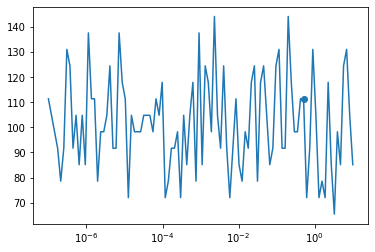

0.5094138014816385


In [0]:
n_epochs = 300
data_list = generateReconsDataset(im_dims)
train_images, test_images = split_data(data_list)

n_samples = train_images.shape[0]
sample_dims = train_images[0].shape

# Training parameters
batch_size = 16
n_batches  = 16
learn_rate = 3e-4

# Networks (note: PredNet does not use my_recons, because it produces reconstructions itself)
# my_model, model_name = PredNet((1, 32, 64), (1, 32, 64)), 'large_prednet' 
# my_model, model_name = PredNet((1, 8, 16), (1, 8, 16)), 'large_prednet_2' 
# my_model, model_name = conv2D_LSTM, 'conv2D_lstm'
# my_model, model_name = simple_RNN, 'simple_RNN'
# my_model, model_name = simple_LSTM, 'simple_lstm'
# my_model, model_name = R2UNet(), 'R2Unet'
my_model, model_name = simple_GRU, 'large_gru'
wrap = Wrapper(my_model, my_recons, my_decoder)

# Uncomment the 3 lines below to select the best learning rate, then comment and run again
learn_rate = wrap.lr_finder(batch_size, mode='decoder')
print(learn_rate)

Reconstruction training

In [0]:
n_epochs = 300
data_list = generateReconsDataset(im_dims)
train_images, test_images = split_data(data_list)

n_samples = train_images.shape[0]
sample_dims = train_images[0].shape

# Training parameters
batch_size = 16
n_batches  = 16
learn_rate = 2e-3

# Networks (note: PredNet does not use my_recons, because it produces reconstructions itself)
# my_model, model_name = PredNet((1, 32, 64), (1, 32, 64)), 'large_prednet' 
# my_model, model_name = PredNet((1, 8, 16), (1, 8, 16)), 'large_prednet_2' 
# my_model, model_name = conv2D_LSTM, 'conv2D_lstm_1'
# my_model, model_name = simple_RNN, 'simple_RNN'
my_model, model_name = simple_LSTM, 'simple_lstm'
# my_model, model_name = R2UNet(), 'R2Unet'
# my_model, model_name = simple_GRU, 'large_gru'
wrap = Wrapper(my_model, my_recons, my_decoder)

# Uncomment the 3 lines below to select the best learning rate, then comment and run again
# learn_rate = wrap.lr_finder(batch_size, mode='reconstruct')
# print(learn_rate)
# a = 1./0.
opt = tf.keras.optimizers.Adam(learn_rate)

# Checkpoint (save and load model weights) 
mckpt    = tf.train.Checkpoint(step=tf.Variable(0), optimizer=opt, net=my_model)
mmanager = tf.train.CheckpointManager(mckpt, './gdrive/My Drive/LabImm/' + model_name + '/mckpt', max_to_keep=1)
mckpt.restore(mmanager.latest_checkpoint)
rckpt    = tf.train.Checkpoint(step=tf.Variable(0), optimizer=opt, net=my_recons)
rmanager = tf.train.CheckpointManager(rckpt, './gdrive/My Drive/LabImm/' + model_name +'/rckpt', max_to_keep=1)
rckpt.restore(rmanager.latest_checkpoint)
dckpt    = tf.train.Checkpoint(step=tf.Variable(0), optimizer=opt, net=my_decoder)
dmanager = tf.train.CheckpointManager(dckpt, './gdrive/My Drive/LabImm/' + model_name + '/dckpt', max_to_keep=1)
dckpt.restore(dmanager.latest_checkpoint)

print(mckpt.step)

losses = np.zeros((n_epochs, 1))

# Training loop for the reconstruction part
train_reconstructions = True
if train_reconstructions:
  for e in range(n_epochs):
    mod_e      = int(e % (n_samples/(batch_size*n_batches)-1))
    epoch_imgs = train_images[mod_e:mod_e+batch_size*n_batches]
    for b in range(n_batches):
      batch_imgs = make_fuzzy_motion_batch(epoch_imgs[b*batch_size:(b+1)*batch_size])
      loss = wrap.train_step(batch_imgs, b, rckpt.step, opt, None, train_reconstructions)
      if (b == 0):
        losses[e] = loss.numpy()
        # To plot heatmap
        '''if (e % 10 == 0):
          wrap.plot_neuron_heatmap(batch_imgs[0,:,:,:,:], wrap.model(batch_imgs)[-1][0])'''
      # wrap.model.reset_states() --> seems to alter learning
    rckpt.step.assign_add(1)
    mckpt.step.assign_add(1)
    if int(rckpt.step) % 10 == 0:
      np.savetxt('./gdrive/My Drive/LabImm/' + model_name + 'new_losses' + str(e) + '.txt', losses)
      if e > 10:
        os.remove('./gdrive/My Drive/LabImm/' + model_name + 'new_losses' + str(e-10) + '.txt')
      
      save_path = mmanager.save()
      print("Saved checkpoints for step {}: {}".format(int(mckpt.step), save_path))
      save_path = rmanager.save()
      print("Saved checkpoints for step {}: {}".format(int(rckpt.step), save_path))

Decoder training

In [0]:
n_epochs = 300
d_losses = np.zeros((n_epochs))
decoder_list, decoder_labels, _ = generateDecoderDataset(im_dims)
train_images, test_images, train_labels, test_labels = split_data(decoder_list, decoder_labels)

n_samples = train_images.shape[0]
sample_dims = train_images[0].shape

# Training parameters
batch_size = 16
n_batches  = 16
learn_rate = 2e-3

# Networks (note: PredNet does not use my_recons, because it produces reconstructions itself)
my_model, model_name = PredNet((1, 32, 64), (1, 32, 64)), 'large_prednet'
# my_model, model_name = PredNet((1, 8, 16), (1, 8, 16)), 'large_prednet_2'  
# my_model, model_name = conv2D_LSTM, 'conv2D_lstm'
# my_model, model_name = simple_RNN, 'simple_RNN'
# my_model, model_name = simple_LSTM, 'simple_lstm'
# my_model, model_name = simple_GRU, 'simple_gru'
wrap = Wrapper(my_model, my_recons, my_decoder)

# Uncomment the 3 lines below to select the best learning rate, then comment and run again
#learn_rate = wrap.lr_finder(batch_size, mode='decoder')
#print(learn_rate)
#a = 1./0.
opt = tf.keras.optimizers.Adam(learn_rate)

# Checkpoint (save and load model weights) 
mckpt    = tf.train.Checkpoint(step=tf.Variable(0), optimizer=opt, net=my_model)
mmanager = tf.train.CheckpointManager(mckpt, './gdrive/My Drive/LabImm/' + model_name + '/mckpt', max_to_keep=1)
mckpt.restore(mmanager.latest_checkpoint)
rckpt    = tf.train.Checkpoint(step=tf.Variable(0), optimizer=opt, net=my_recons)
rmanager = tf.train.CheckpointManager(rckpt, './gdrive/My Drive/LabImm/' + model_name + '/rckpt', max_to_keep=1)
rckpt.restore(rmanager.latest_checkpoint)
dckpt    = tf.train.Checkpoint(step=tf.Variable(0), optimizer=opt, net=my_decoder)
dmanager = tf.train.CheckpointManager(dckpt, './gdrive/My Drive/LabImm/' + model_name + '/dckpt2', max_to_keep=1)
dckpt.restore(dmanager.latest_checkpoint)

print(mckpt.step)
print(dckpt.step)

'''if (int(dckpt.step) != 0):
  epoch = int(dckpt.step)
  print('Found checkpoint at epoch: ' + repr(epoch))
  filename = './gdrive/My Drive/' + model_name + '/' + model_name + '_dlosses' + str(epoch-1) + '.txt'
  losses = np.loadtxt(filename, dtype='float')
else:
  losses = np.zeros((n_epochs, 1))'''

losses = np.zeros((n_epochs, 1))

# Training loop for the decoding part
train_decoder = True
if train_decoder:
  for e in range(n_epochs):
    mod_e      = int(e % (n_samples/(batch_size*n_batches)-1))
    epoch_imgs = train_images[mod_e:mod_e+batch_size*n_batches]
    epoch_labels = train_labels[mod_e:mod_e+batch_size*n_batches]
    for b in range(n_batches):
      if (random.random() < 0.5):
        batch, labels = make_decoder_batch2(16, n_verniers=5)
        batch_labels = tf.tile(tf.expand_dims(labels, axis=-1), (1,n_frames))
      else:
        batch = make_decoder_batch(epoch_imgs[b*batch_size:(b+1)*batch_size], n_verniers=5)
        batch_labels = tf.tile(tf.expand_dims(epoch_labels[b*batch_size:(b+1)*batch_size], axis=-1), (1,n_frames))
      loss = wrap.train_step(batch, b, dckpt.step, opt, batch_labels, train_reconstructions=False)
      if (b == 0):
        losses[e] = loss.numpy()
        # To plot heatmap
        '''if (e % 10 == 0):
          wrap.plot_neuron_heatmap(batch[0,:,:,:,:], wrap.model(batch)[-1][0])'''
      #wrap.model.reset_states()''' --> seems to alter learning
    dckpt.step.assign_add(1)
    if int(dckpt.step) % 10 == 0:
      np.savetxt('./gdrive/My Drive/LabImm/' + model_name + '_d_losses' + str(e) + '.txt', losses)
      if e > 10:
        os.remove('./gdrive/My Drive/LabImm/' + model_name + '_d_losses' + str(e-10) + '.txt')
      
      save_path = dmanager.save()
      print("Saved checkpoints for step {}: {}".format(int(dckpt.step), save_path))

Testing

In [49]:
n_epochs = 1000

n_frames = 13

# Networks (note: PredNet does not use my_recons, because it produces reconstructions itself)
my_model, model_name = PredNet((1, 32, 64), (1, 32, 64)), 'large_prednet' 
# my_model, model_name = conv2D_LSTM, 'conv2D_lstm'
# my_model, model_name = simple_RNN, 'simple_RNN'
# my_model, model_name = simple_LSTM, 'simple_lstm'
# my_model, model_name = simple_GRU, 'large_gru'
wrap = Wrapper(my_model, my_recons, my_decoder)

learn_rate = 3e-4
batch_size = 1

# Uncomment the 3 lines below to select the best learning rate, then comment and run again
#learn_rate = wrap.lr_finder(batch_size, mode='decoder')
#print(learn_rate)
#a = 1./0.
opt = tf.keras.optimizers.Adam(learn_rate)

# Checkpoint (save and load model weights) 
mckpt    = tf.train.Checkpoint(step=tf.Variable(0), optimizer=opt, net=my_model)
mmanager = tf.train.CheckpointManager(mckpt, './gdrive/My Drive/LabImm/' + model_name + '/mckpt', max_to_keep=1)
mckpt.restore(mmanager.latest_checkpoint)
rckpt    = tf.train.Checkpoint(step=tf.Variable(0), optimizer=opt, net=my_recons)
rmanager = tf.train.CheckpointManager(rckpt, './gdrive/My Drive/LabImm/' + model_name + '/rckpt', max_to_keep=1)
rckpt.restore(rmanager.latest_checkpoint)
dckpt    = tf.train.Checkpoint(step=tf.Variable(0), optimizer=opt, net=my_decoder)
dmanager = tf.train.CheckpointManager(dckpt, './gdrive/My Drive/LabImm/' + model_name + '/dckpt2', max_to_keep=1)
dckpt.restore(dmanager.latest_checkpoint)

print(dckpt.step)

all_dominances = []
thresh_dominances = []
entropies, zscores, variances = [], [], []
b = 0

variance_thresh = 0.03 # For now, arbitrary value

# Training loop for the decoding part
test_decoder = True
if test_decoder:
  for e in range(n_epochs):
    # Create empty frames (default label = True)
    init_batch = tf.stack([addNoise(np.zeros(im_dims)) for i in range(3)])
    init_labels = tf.stack([True for i in range(3)])

    # SQM generation
    batch, batch_labels = generateTestSet(im_dims, case='v')

    # Concatenate frames and labels
    batch = tf.concat([init_batch, batch],0)
    batch_labels = tf.concat([init_labels, batch_labels],0)
    
    assert(batch.shape[0] == 13)

    batch = tf.tile(tf.expand_dims(batch, axis=0), (batch_size, 1, 1, 1, 1))
    batch = tf.cast(batch, dtype=tf.float32)
    batch_labels = tf.tile(tf.expand_dims(batch_labels, axis=0), (batch_size, 1))
    # Get label predictions
    preds = wrap.get_predictions(batch)

    # Get entropies
    wrap.model.reset_states()
    entropies.append(wrap.stats(batch, entropy))

    # Get variances
    wrap.model.reset_states()
    variances.append(wrap.stats(batch, moment, moment=2))

    #thresh_idx = np.where(np.asarray(var) > variance_thresh)[0]

    loss, frame_losses, dominances = wrap.pred_test_loss(batch_labels, preds)
    all_dominances.append(dominances)
    #thresh_dominances.extend(np.asarray(dominances)[thresh_idx])
    print('\nStarting epoch %3i with loss = %5.2f' % (e, loss))
    wrap.model.reset_states()
    #wrap.plot_output(batch)
    #wrap.model.reset_states()

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=300>
tf.Tensor([0.618466   0.38153398], shape=(2,), dtype=float32)
tf.Tensor([0.2934584 0.7065416], shape=(2,), dtype=float32)
tf.Tensor([0.18129525 0.8187048 ], shape=(2,), dtype=float32)
tf.Tensor([0.09345155 0.90654844], shape=(2,), dtype=float32)
tf.Tensor([0.2053219  0.79467815], shape=(2,), dtype=float32)
tf.Tensor([0.9228982  0.07710183], shape=(2,), dtype=float32)
tf.Tensor([0.87987465 0.12012538], shape=(2,), dtype=float32)
tf.Tensor([0.69269437 0.30730566], shape=(2,), dtype=float32)
tf.Tensor([0.7615397  0.23846035], shape=(2,), dtype=float32)
tf.Tensor([9.9919957e-01 8.0050423e-04], shape=(2,), dtype=float32)
CV dominance:  [1, 0, 0, 0, 0, 1, 1, 1, 1, 1]

Starting epoch   0 with loss = 16.26
tf.Tensor([0.73894143 0.2610586 ], shape=(2,), dtype=float32)
tf.Tensor([0.3681185 0.6318815], shape=(2,), dtype=float32)
tf.Tensor([0.19000661 0.8099934 ], shape=(2,), dtype=float32)
tf.Tensor([0.19689313 0.8031069 ], shape=(2,), dt

CVD plot

Text(8, 0.863, '0.513')

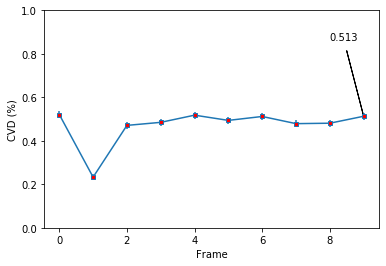

In [50]:
#plt.plot(range(10), np.mean(np.asarray(all_dominances), 0))
#print(np.std(np.asarray(all_dominances),0).shape)
plt.errorbar(range(10), np.mean(np.asarray(all_dominances), 0), ss.sem(np.asarray(all_dominances), 0), marker='s', mfc='red', ms=4)
plt.ylim(bottom=0, top=1)
plt.ylabel('CVD (%)')
plt.xlabel('Frame')

last_value = np.mean(np.asarray(all_dominances), 0)[-1]
plt.arrow(9, last_value, -0.5, 0.3)
plt.annotate(str(last_value), xy=(8, last_value+0.35))

Entropy plot

Text(0.5, 1.0, 'Entropies')

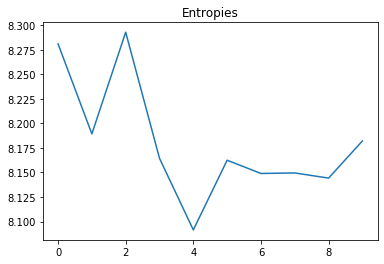

In [51]:
plt.plot(range(10), np.mean(np.asarray(entropies),0))
plt.title('Entropies')

Variance plot

Text(0.5, 1.0, 'Var')

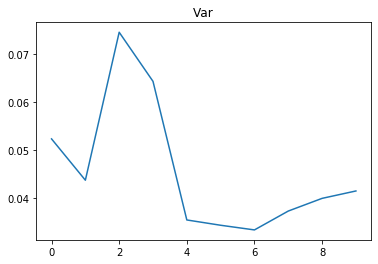

In [52]:
plt.plot(range(10), np.mean(np.asarray(variances),0))
plt.title('Var')